In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pyro
import pyro.distributions as dist
import pyro.contrib.bnn as bnn
from pyro import infer
from pyro import optim
from pyro.distributions import constraints

from torchvision import datasets, transforms

In [2]:
# Create loaders for train and test data sets
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=None)

In [3]:
# First try linear model similar to in previous
class BNN(nn.Module):
    """Bayesian neural network for categorical classification
    """
    
    def __init__(self, n_classes=10, hidden_sizes=[100, 100]):
        super(BNN, self).__init__()
        self.n_classes = n_classes
        self.hidden_sizes = hidden_sizes
        self.n_hidden = len(hidden_sizes)
    
    def model(self, X, y=None, kl_factor=1):
        n_input = X.size(0)
        # Flatten features
        X = X.view(n_input, -1)
        n_features = X.size(1)
        if y is not None:
            y = nn.functional.one_hot(y, num_classes=self.n_classes)
        # standard normal priors on weights
        a_inp_mean = torch.zeros(n_features, self.hidden_sizes[0])
        a_inp_scale = torch.ones(n_features, self.hidden_sizes[0])
        a_hidden_means = [
            torch.zeros(self.hidden_sizes[i]+1, self.hidden_sizes[i+1]) \
                for i in range(self.n_hidden - 1)
        ]
        a_hidden_scales = [
            torch.ones(self.hidden_sizes[i]+1, self.hidden_sizes[i+1]) \
                for i in range(self.n_hidden - 1)
        ]
        a_out_mean = torch.zeros(self.hidden_sizes[self.n_hidden-1]+1, self.n_classes)
        a_out_scale = torch.ones(self.hidden_sizes[self.n_hidden-1]+1, self.n_classes)
        # make batches conditionally independent given params
        with pyro.plate('data', size=n_input):
            x = pyro.sample('h_inp', bnn.HiddenLayer(X, a_inp_mean, a_inp_scale, KL_factor=kl_factor))
            for i in range(self.n_hidden - 1):
                x = pyro.sample(f'h{i+1}', bnn.HiddenLayer(x, a_hidden_means[i], a_hidden_scales[i],
                                                           KL_factor=kl_factor))
            lp = pyro.sample('h_out', bnn.HiddenLayer(x, a_out_mean, a_out_scale,
                                                      non_linearity=lambda x: torch.log_softmax(x, dim=-1),
                                                      KL_factor=kl_factor, include_hidden_bias=False))
            # Likelihood is multinomial based on softmax output of last layer
            return pyro.sample('out', dist.OneHotCategorical(logits=lp), obs=y)
    
    def guide(self, X, y=None, kl_factor=1):
        n_input = X.size(0)
        X = X.view(n_input, -1)
        n_features = X.size(1)
        a_inp_mean = pyro.param('a_inp_mean', 0.01 * torch.randn(n_features, self.hidden_sizes[0]))
        a_inp_scale = pyro.param('a_inp_scale', 0.1 * torch.ones(n_features, self.hidden_sizes[0]),
                                  constraint=constraints.positive)
        a_hidden_means = [
            pyro.param(f'a_hidden{i}_mean',
                       0.01 * torch.randn(self.hidden_sizes[i]+1, self.hidden_sizes[i+1])) \
                for i in range(self.n_hidden - 1)
        ]
        a_hidden_scales = [
            pyro.param(f'a_hidden{i}_scale',
                       0.1 * torch.ones(self.hidden_sizes[i]+1, self.hidden_sizes[i+1]),
                       constraint=constraints.positive) \
                for i in range(self.n_hidden - 1)
        ]
        a_out_mean = pyro.param('a_out_mean',
                                0.01 * torch.randn(self.hidden_sizes[self.n_hidden-1]+1, self.n_classes))
        a_out_scale = pyro.param('a_out_scale',
                                 0.1 * torch.ones(self.hidden_sizes[self.n_hidden-1]+1, self.n_classes),
                                 constraint=constraints.positive)
        with pyro.plate('data', size=n_input):
            x = pyro.sample('h_inp', bnn.HiddenLayer(X, a_inp_mean, a_inp_scale, KL_factor=kl_factor))
            for i in range(self.n_hidden - 1):
                x = pyro.sample(f'h{i+1}', bnn.HiddenLayer(x, a_hidden_means[i], a_hidden_scales[i],
                                                           KL_factor=kl_factor))
            lp = pyro.sample('h_out', bnn.HiddenLayer(x, a_out_mean, a_out_scale,
                                                      non_linearity=lambda x: torch.log_softmax(x, dim=-1),
                                                      KL_factor=kl_factor, include_hidden_bias=False))
    
    def forward(self, X, n_samples=1):
        """Sample from guide with X as input and return stack of output"""
        res = [
            pyro.poutine.trace(self.guide).get_trace(X).nodes['h_out']['value'] \
            for _ in range(n_samples)
        ]
        return torch.stack(res, dim=0)
    
    def infer(self, loader, lr=0.01, num_epochs=5):
        """Fit the model.
        
        loader is the data loader (type torch.utils.DataLoader) to use (e.g. train_loader from above)
        lr is the learning rate of the Adam optimizer for gradient descent
        num_epochs is the number of times to iterate of the entire training set
        """
        optimizer = optim.Adam({'lr': lr})
        elbo = infer.TraceMeanField_ELBO()  # Optimizer will maximize ELBO
        svi = infer.SVI(self.model, self.guide, optimizer, elbo)
        total_size = len(loader.dataset)
        for i in range(num_epochs):
            total_loss = 0
            correct = 0
            for X, y in loader:
                loss = svi.step(X, y, kl_factor=X.size(0) / total_size)
                pred = self.forward(X).mean(axis=0)
                total_loss += loss
                correct += (pred.argmax(-1) == y).sum().item()
                param_store = pyro.get_param_store()
            print(f'Epoch {i+1}: loss = {total_loss:.5E}, accuracy = {correct / total_size:.5f}')


In [4]:
pyro.clear_param_store()
bayesian_nn = BNN(n_classes=10, hidden_sizes=[50, 30])
%time bayesian_nn.infer(train_loader, lr=0.01, num_epochs=5)

Epoch 1: loss = -8.24246E+05, accuracy = 0.88588
Epoch 2: loss = -5.10960E+06, accuracy = 0.95103
Epoch 3: loss = -1.31902E+07, accuracy = 0.95482
Epoch 4: loss = -2.45809E+07, accuracy = 0.95605
Epoch 5: loss = -3.90777E+07, accuracy = 0.95560
CPU times: user 7min 15s, sys: 2min 32s, total: 9min 48s
Wall time: 3min 23s


In [5]:
def predict(x, n_samp=100, make_hist=True):
    """Does out of sample posterior prediction using fitted bayesian_nn
    
    n_samp is the number of draws from the posterior to take
    if make_hist, will generate histograms for the probability parameters of all draws
    """
    with torch.no_grad():
        pred = bayesian_nn.forward(x, n_samp)
    if make_hist:
        for i in range(pred.shape[2]):
            plt.hist(pred[:,:,i].flatten().exp())  # output is log prob, so exponentiate
            plt.title(f'Histogram of probabilities for {i}')
            plt.show()
    # Return most probable digit
    return pred.mean(axis=0).argmax(-1).item()

def show(x):
    x = x.squeeze()
    plt.imshow(x, cmap='gray')
    plt.show()

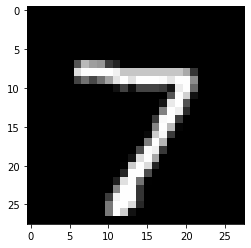

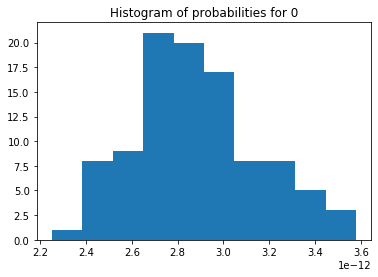

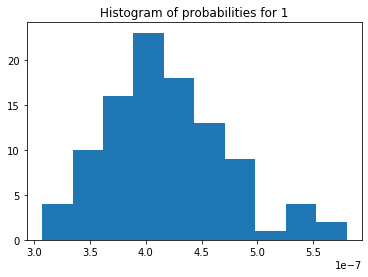

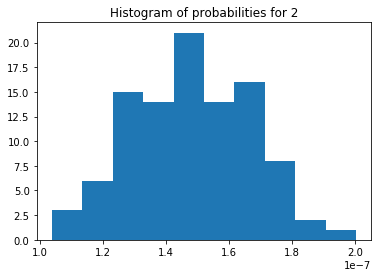

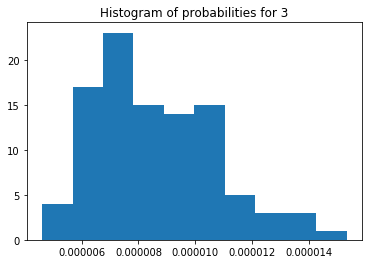

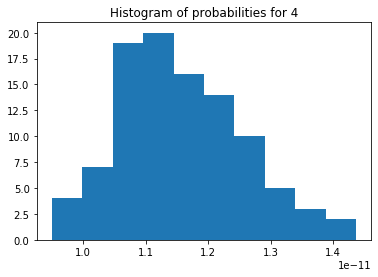

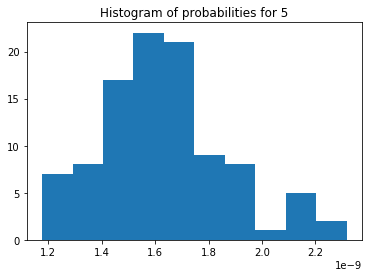

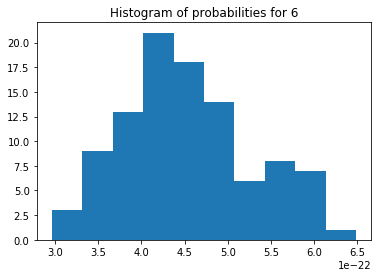

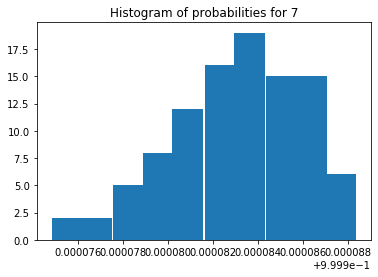

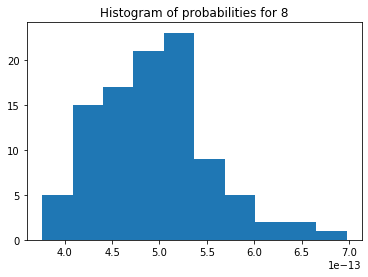

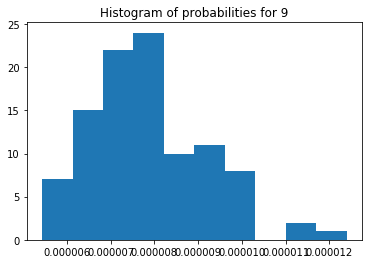

predicted was 7, actual is 7


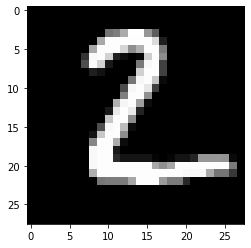

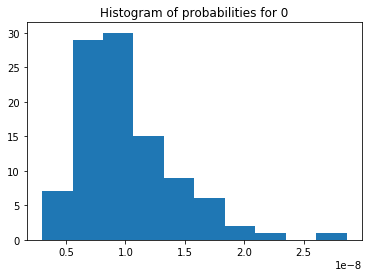

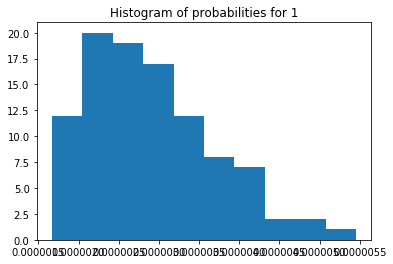

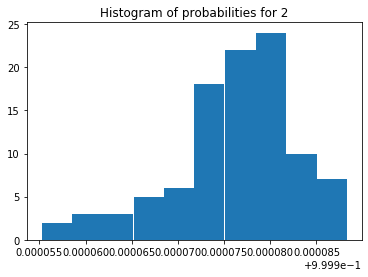

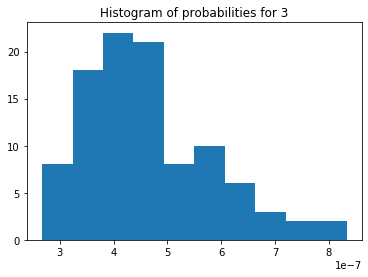

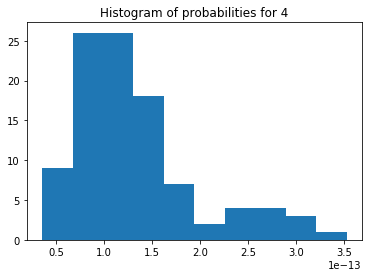

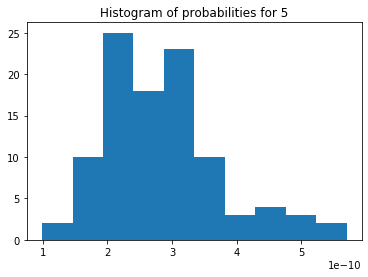

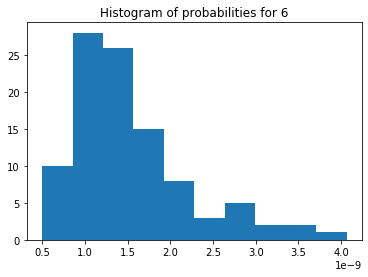

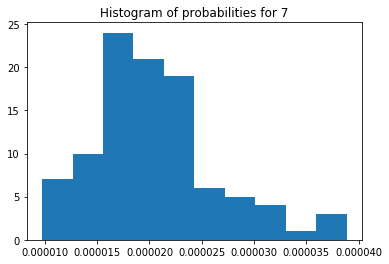

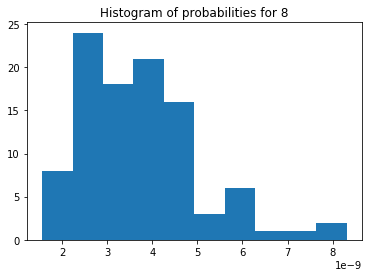

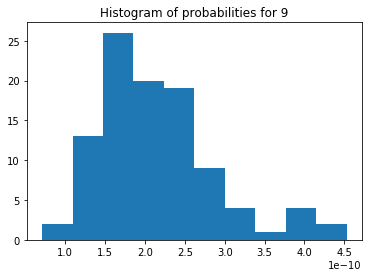

predicted was 2, actual is 2


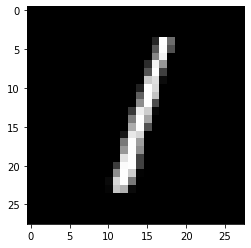

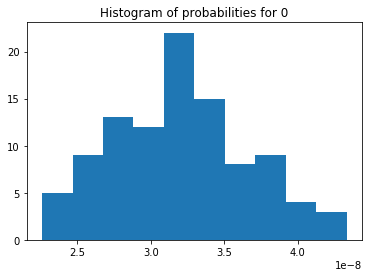

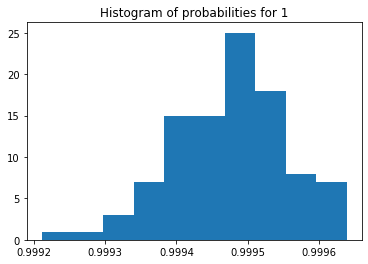

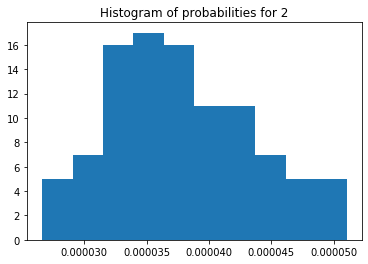

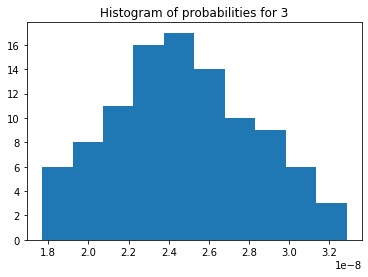

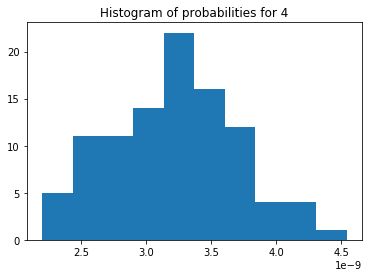

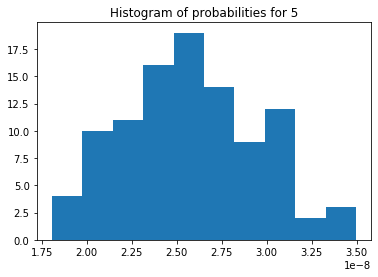

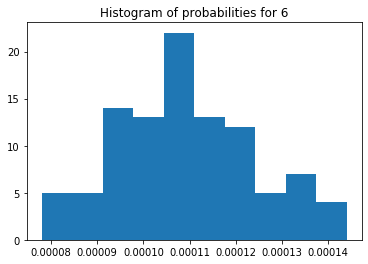

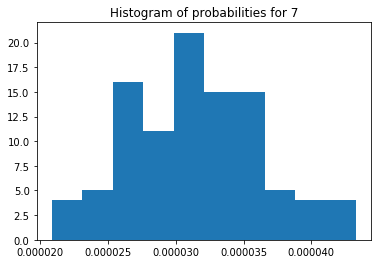

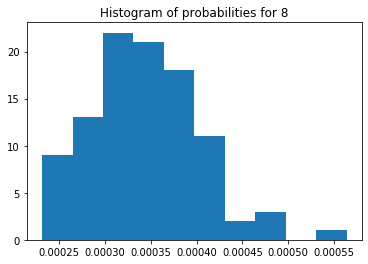

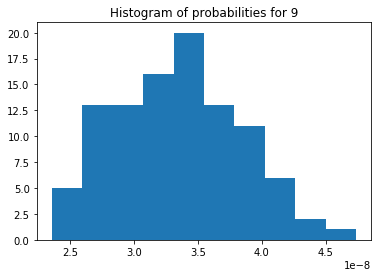

predicted was 1, actual is 1


In [7]:
# How does the net behave when given a real value?
iterloader = iter(test_loader)
for _ in range(3):  # Try 3 different values
    X_test, y_test = next(iterloader)
    show(X_test)
    pred = predict(X_test)
    print(f'predicted was {pred}, actual is {y_test}')

It does a good job classifying all of these. The distributions for each parameter are all very narrow (to a point that it matplotlib seems to have a hard time with it for some reason).

In [8]:
# Calculate accuracy over the entire testing set
correct = 0
total = 0
for X, y in test_loader:
    pred = predict(X, n_samp=1, make_hist=False)
    correct += (pred == y)
    total += 1

print(f'accuracy on test set is {correct / total}')

accuracy on test set is 0.9431


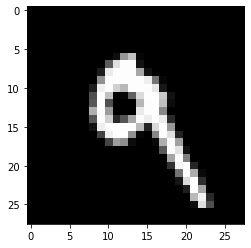

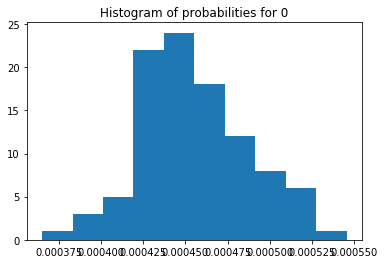

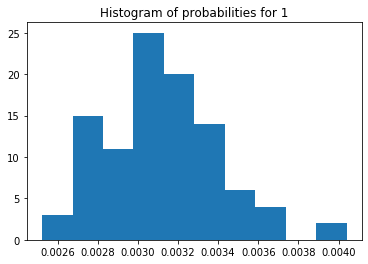

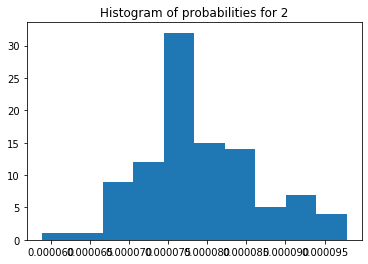

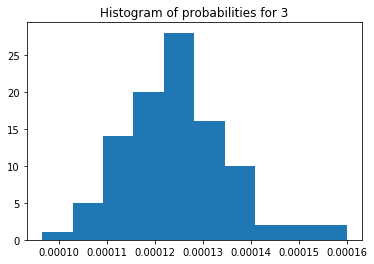

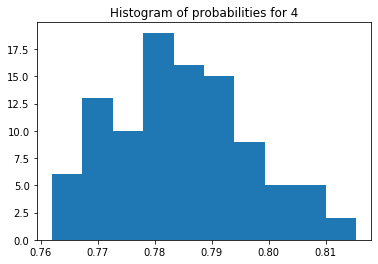

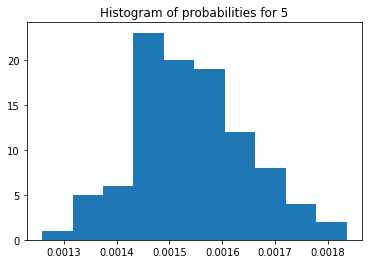

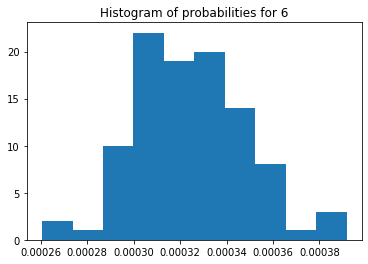

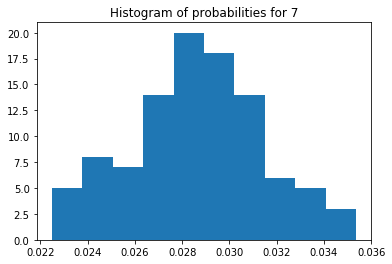

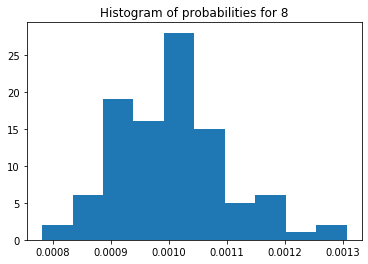

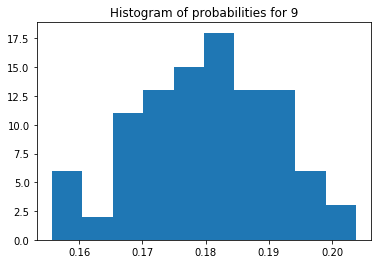

predicted was 4, actual is 9


In [9]:
# How does it behave on digits it gets wrong?
for X, y in test_loader:
    # iterate until we get something wrong
    if predict(X, n_samp=10, make_hist=False) != y:
        show(X)
        pred = predict(X, make_hist=True)
        print(f'predicted was {pred}, actual is {y}')
        break

Parameter distributions are much wider for incorrect values. This is great -- the model is able to indicate when it is uncertain.

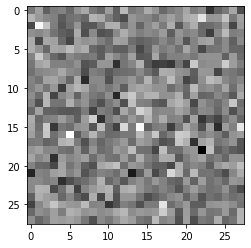

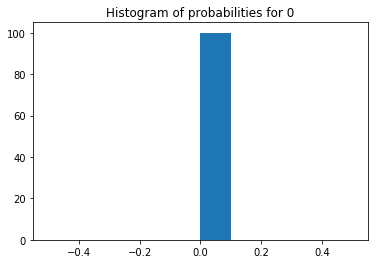

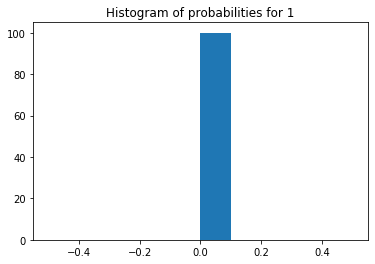

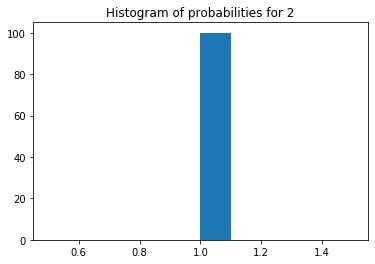

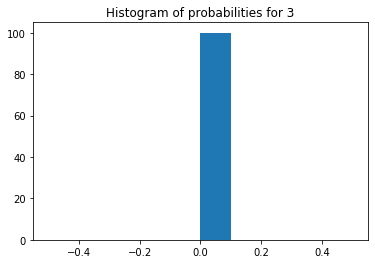

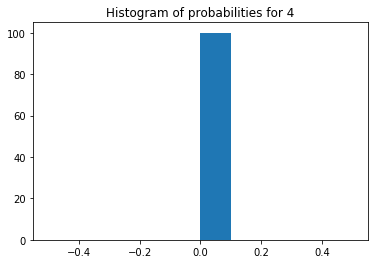

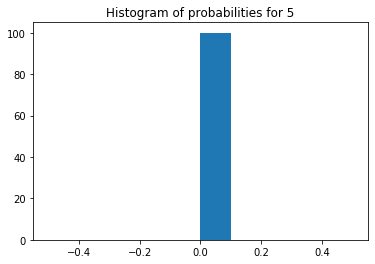

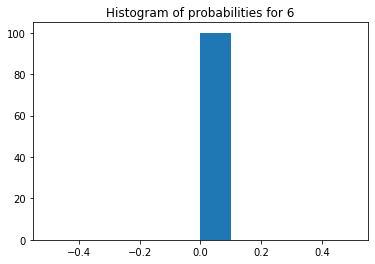

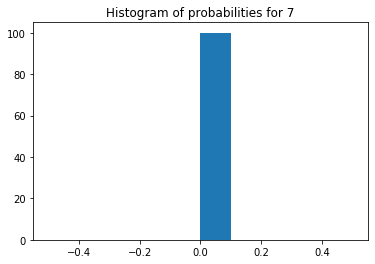

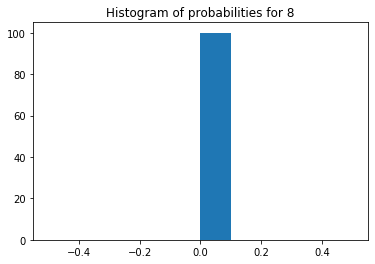

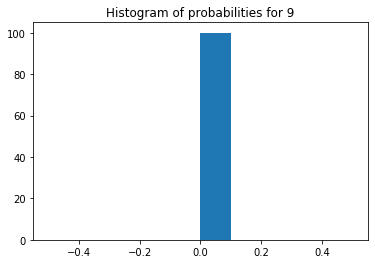

2

In [6]:
# How does the net behave when given white noise?
X_dummy = torch.randn(1, 28, 28)
show(X_dummy)
predict(X_dummy)

Apparently it is very confident that white noise is a 2. This is one issue with neural networks: if they encounter data different from what they were trained on, they perform very poorly. I think that in theory a fully Bayesian neural network should be resistant to this problem, although the contraints of the variational inference approach I use here make it a bit less robust to this kind of error.